In [4]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import keras
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # manipulating tensors
from gensim.models import KeyedVectors # library for importing pretrained WordEmbeddings
from tensorflow.keras.preprocessing.text import Tokenizer # used to tokenize textsequence
from tensorflow.keras.preprocessing.sequence import pad_sequences # padding sequences to the same length
from sklearn.model_selection import train_test_split # split data into training and validation set 
from tensorflow.keras.models import Sequential # building sequential models like FF layer in the transformer encoder
from tensorflow.keras.layers import Dense,Embedding # used for parts of the transformer encoder
from tensorflow.keras import layers
import re # Regex for standardizing text

In [2]:
# reading data into a data.frame
fake = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv',delimiter=',',encoding='utf-8')
real = pd.read_csv('../input/fake-and-real-news-dataset/True.csv',delimiter=',',encoding='utf-8')

# adding a new column 'label' containing the labels
fake['label'] = 'fake'
real['label'] = 'real'

# concatinating both data.frames, shuffling them and remove unnecessary columns
df = pd.concat([fake, real], axis=0)
df = df.sample(frac = 1) # shuffles the whole data frame
df = df.drop('subject', axis=1)
df = df.drop('date', axis=1)
df = df.drop('title', axis=1)

# replacing the labels for integers, necessary for the loss function
df['label'] = df['label'].replace({'real':0, 'fake':1})

print("Number of fake Articles:", len(df.loc[df['label'] == 1]))
print("Number of real Articles:", len(df.loc[df['label'] == 0]))
df.head()



Number of fake Articles: 23481
Number of real Articles: 21417


,text,label
18620,BARCELONA (Reuters) - Tens of thousands of Cat...,0
21550,Greg Gutfield asks the question we all would l...,1
15265,"JAKARTA/TIMIKA, Indonesia (Reuters) - Armed se...",0
9424,"HO CHI MINH CITY, Vietnam (Reuters) - Washingt...",0
15835,We have not observed the principles and ideal...,1


In [3]:
# iterating over the messages and standardizing them with case conversion, removing numbers, punctuation and white space
new_sentences = []
for article in df['text']:
    norm_article = article.lower() # changing all letters to lowercase
    norm_article = re.sub(r'\d+','',norm_article) # \d+ removing one or more digits [0-9]
    norm_article = re.sub(r'[^\w\s]','', norm_article) # removing all characters that are not alphaNumeric or whitespace e.g. tab or space
    norm_article = norm_article.strip() # removing spaces at the beginning and end of a sentence e.g.   "    spam    "  -> "spam"
    norm_article = ' '.join(norm_article.split()[15:]) # discarding the first 15 words of each article 
    new_sentences.append(norm_article)
df['New_Text'] = new_sentences # adding new column with the standardized message
df.head()

,text,label,New_Text
18620,BARCELONA (Reuters) - Tens of thousands of Cat...,0,to vote in a banned independence referendum on...
21550,Greg Gutfield asks the question we all would l...,1,working for planned parenthood in the undercov...
15265,"JAKARTA/TIMIKA, Indonesia (Reuters) - Armed se...",0,to disrupt freeportmcmoran inc s giant grasber...
9424,"HO CHI MINH CITY, Vietnam (Reuters) - Washingt...",0,of lethal weapons to vietnam is not aimed at c...
15835,We have not observed the principles and ideal...,1,makes sure to let everyone know americans neve...


In [4]:
train_x,test_x,train_y,test_y=train_test_split(df['New_Text'],df['label'],test_size=0.3,random_state=42) # split data into train and test data 70%-30%

In [5]:
# the labels need to be in a list for matching data types during training
train_y_tolist = train_y.tolist()
test_y_tolist = test_y.tolist()

In [6]:
# restrict vocabulary to the 20000 most frequent words
num_words= 20000
tokenizer = Tokenizer(num_words=num_words) # used to tokenize our messages

tokenizer.fit_on_texts(train_x) # updates internal vocabulary. Each word in train_x gets assigned to a specific integer, so to say an ID. E.g. {the,1}, {news,2}, {evening, 3}

vocab_size = num_words 

train_x_seq=tokenizer.texts_to_sequences(train_x) # converts the tokens of a text corpus into a sequence of integers, e.g "the evening news" -> [1, 3, 2]
test_x_seq=tokenizer.texts_to_sequences(test_x)


In [7]:
# converting each sequence into a vector of dimension 15,000 by building the sum over all one-hot encoded vectors of the sequence
train_x_vec = []
for seq in train_x_seq:
    vector=[0]*vocab_size
    for w in seq:
        if w < vocab_size+1:
            vector[w-1]= vector[w-1] + 1
    train_x_vec.append(vector)

test_x_vec = []
for seq in test_x_seq:
    vector=[0]*vocab_size
    for w in seq:
        if w < vocab_size+1:
            vector[w-1]= vector[w-1] + 1
    test_x_vec.append(vector)



In [8]:
# building the model:
inputs = keras.Input(shape = (vocab_size,), dtype="int64")
outputs = layers.Dense(1, activation="sigmoid")(inputs)
model = keras.Model(inputs, outputs)

model.compile(loss='mse',optimizer='SGD',metrics=['accuracy'])
epochs=30

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dense (Dense)                (None, 1)                 20001     
Total params: 20,001
Trainable params: 20,001
Non-trainable params: 0
_________________________________________________________________


2022-11-18 13:14:07.917740: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [9]:
# training the model
result=model.fit(train_x_vec,train_y_tolist, epochs=epochs, shuffle=True, validation_data=(test_x_vec,test_y_tolist))

2022-11-18 14:09:08.861358: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
983/983 [==============================] - 1419s 1s/step - loss: 0.0781 - accuracy: 0.9193 - val_loss: 0.0606 - val_accuracy: 0.9464
Epoch 2/30
983/983 [==============================] - 5s 5ms/step - loss: 0.0531 - accuracy: 0.9566 - val_loss: 0.0504 - val_accuracy: 0.9582
Epoch 3/30
983/983 [==============================] - 4s 4ms/step - loss: 0.0469 - accuracy: 0.9625 - val_loss: 0.0456 - val_accuracy: 0.9629
Epoch 4/30
983/983 [==============================] - 4s 5ms/step - loss: 0.0431 - accuracy: 0.9659 - val_loss: 0.0431 - val_accuracy: 0.9647
Epoch 5/30
983/983 [==============================] - 5s 5ms/step - loss: 0.0403 - accuracy: 0.9682 - val_loss: 0.0410 - val_accuracy: 0.9669
Epoch 6/30
983/983 [==============================] - 4s 4ms/step - loss: 0.0382 - accuracy: 0.9700 - val_loss: 0.0390 - val_accuracy: 0.9683
Epoch 7/30
983/983 [==============================] - 5s 5ms/step - loss: 0.0365 - accuracy: 0.9720 - val_loss: 0.0377 - val_accuracy: 0.9689
Epoc

In [10]:
#saving weights for further analysis
weights = model.get_weights() 

In [11]:
# get the positions of the 5 smallest weights
import heapq 

heapq.nsmallest(5, range(len(weights[0])), key=weights[0].__getitem__)

[12, 170, 241, 340, 80]

In [12]:
# get the positions of the 5 biggest weights
heapq.nlargest(5, range(len(weights[0])), key=weights[0].__getitem__)

[42, 161, 8, 79, 129]

In [27]:
# checking the words matching the positions of the biggest/smallest weights - keep in mind, word_index starts at 1, the array of the weights at 0 
k = 0
for item in tokenizer.word_index.items():
    if k < 350:
        print(item)
        k += 1

('the', 1)
('to', 2)
('of', 3)
('and', 4)
('a', 5)
('in', 6)
('that', 7)
('on', 8)
('s', 9)
('for', 10)
('is', 11)
('he', 12)
('said', 13)
('it', 14)
('with', 15)
('was', 16)
('trump', 17)
('as', 18)
('his', 19)
('by', 20)
('has', 21)
('be', 22)
('have', 23)
('not', 24)
('from', 25)
('this', 26)
('at', 27)
('are', 28)
('who', 29)
('they', 30)
('an', 31)
('i', 32)
('but', 33)
('we', 34)
('us', 35)
('would', 36)
('about', 37)
('will', 38)
('their', 39)
('had', 40)
('president', 41)
('you', 42)
('t', 43)
('were', 44)
('been', 45)
('people', 46)
('or', 47)
('more', 48)
('which', 49)
('she', 50)
('her', 51)
('after', 52)
('one', 53)
('its', 54)
('if', 55)
('all', 56)
('out', 57)
('what', 58)
('also', 59)
('when', 60)
('state', 61)
('there', 62)
('up', 63)
('new', 64)
('no', 65)
('over', 66)
('our', 67)
('states', 68)
('government', 69)
('can', 70)
('house', 71)
('clinton', 72)
('him', 73)
('than', 74)
('other', 75)
('so', 76)
('some', 77)
('just', 78)
('could', 79)
('obama', 80)
('told', 81

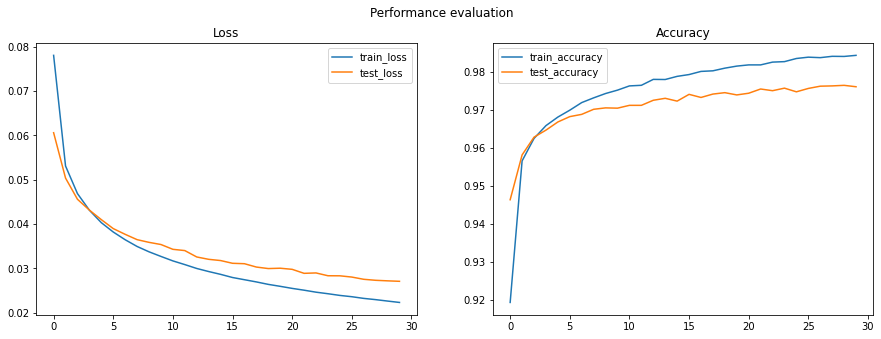

In [14]:
#plot metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(result.history['loss'],label='train_loss')
plt.plot(result.history['val_loss'],label='test_loss')
plt.title("Loss")
plt.legend()
plt.suptitle("Performance evaluation")

plt.subplot(122)
plt.plot(result.history['accuracy'],label='train_accuracy')
plt.plot(result.history['val_accuracy'],label='test_accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()